In [1]:
from monte_carlo import *
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
ndim = 2
nsamples = 1000

target = densities.Camel(ndim)
# add .count attributes to pdf and pot_gradient methods
util.count_calls(target, 'pdf', 'pot_gradient')
start = np.full(ndim, 1/3)

# Markov Updates
The package defines the abstract `MarkovUpdate` which implements a general `sample` function
based on the `next_state(current)` function, that each concrete update must override.
The sample returned is an instance of `MarkovSample` and contains the generated sample as `data`
and provides information such as the mean, variance, and acceptance rate for Metropolis updates.

## Metropolis Updates
Metropolis updates are generally subclasses of `MetropolisUpdate`, which is abstract.
The "default" Metropolis (Hasting) update is implemented in `DefaultMetropolis`.
The metheods, on instantiation, take the sample dimension and a callable target probability
as arguments. The pdf can be a `Density` object, but as opposed to Hamiltonian updates, they
can also be simple functions.

## Default Metropolis Hasting

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  0.3251787699991837
pdf calls:  3900
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.470793 0.4742341],[0.03286367 0.03238225],None,"20.56, p=1.565e-67",0.114


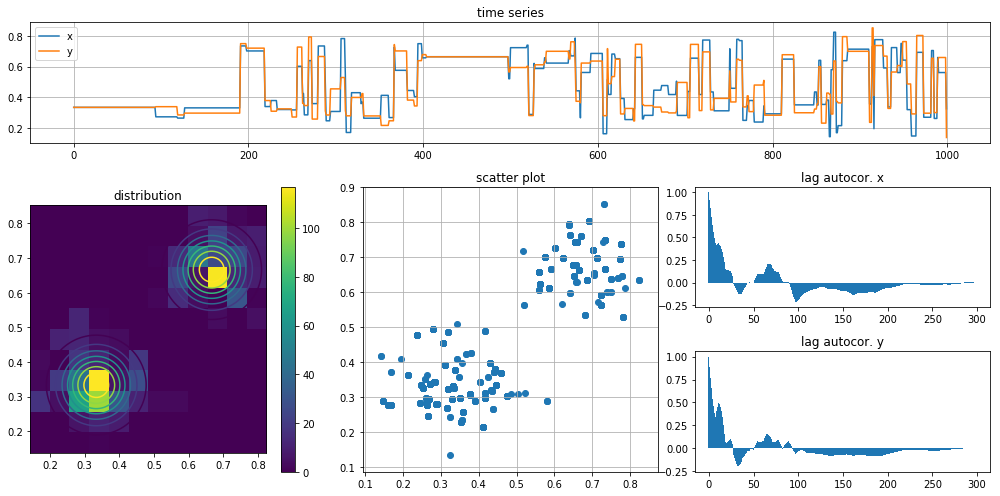

In [3]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

# by default the range for Uniform ins [0, 1]^ndim
proposal = densities.Uniform(ndim)
sampler = DefaultMetropolis(ndim, target, proposal)

# sample
t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

# print info
print('time: ', t_end - t_start)
print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample  # show sample

## Adaptive Metropolis

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  0.6564473059988813
pdf calls:  5400
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.52442484 0.52024699],[0.03140326 0.03004372],None,"8.022, p=2.001e-30",0.171


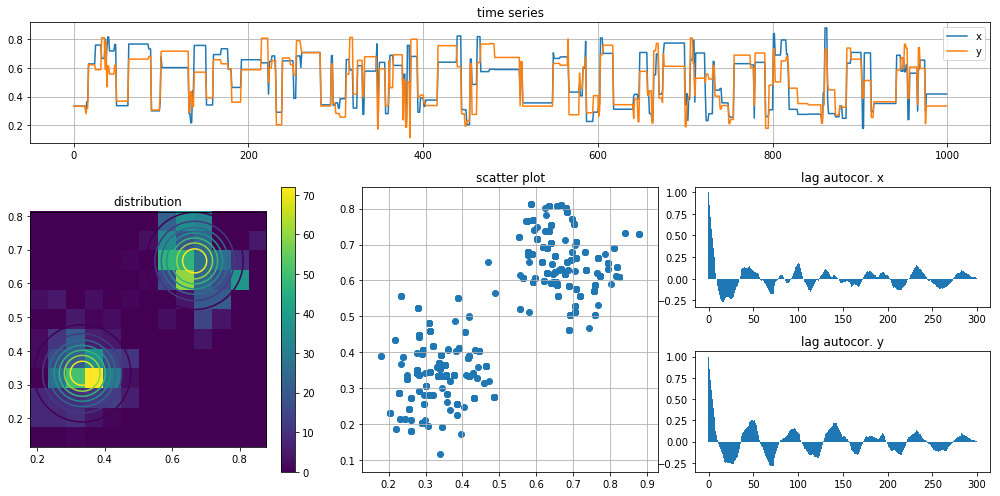

In [10]:
nadapt = 1000
nburnin = 1000

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

# hast to be a proposal with cov attribute
# this is what adaptive metropolis modifies
proposal = densities.Gaussian(ndim, mu=0.5, cov=0.005)
metropolis_sampler = AdaptiveMetropolisUpdate(
    ndim, target.pdf, proposal, t_initial=100,
    adapt_schedule=lambda t: t <= nadapt)

# burn in
metropolis_sampler.sample(nburnin, [0.5, 0.5], log_every=0)
metropolis_sampler.is_adaptive = False  # turn adaptation off

t_start = timer()
sample = metropolis_sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

sample.target = target

print('time: ', t_end - t_start)
print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Hamiltonian Updates
Hamiltonian updates take densities as argument, and therefore don't require a dedicated ndim argument.

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  24.13612096200086
pdf calss:  35269
pot_gradient calls:  61938


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.56421335 0.56453742],[0.02918621 0.02874681],None,"4.798, p=7.009e-14",0.999


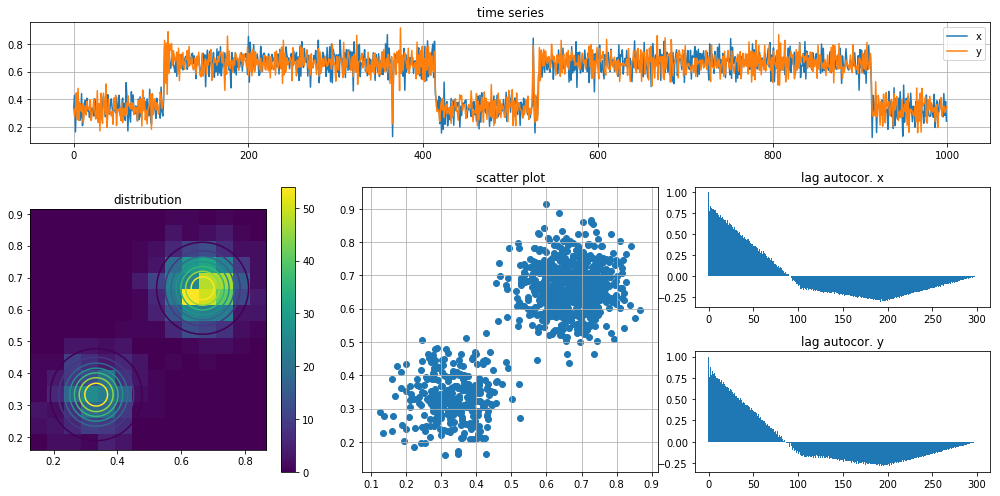

In [12]:
step_size = 0.1
steps = 30

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=10)
sampler = hamiltonian.HamiltonianUpdate(target, momentum_dist, steps, step_size)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Dual Averaging HMC

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  2.407527782001125
pdf calss:  6301
pot_gradient calls:  65938


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.43571345 0.43454238],[0.02936531 0.02985437],None,"6.372, p=2.68e-22",0.519


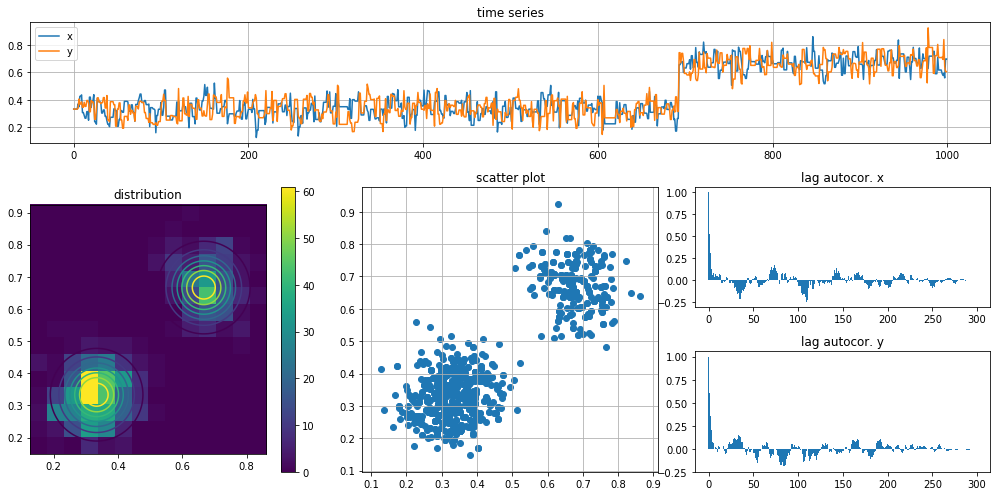

In [14]:
nadapt = 1000

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=.05)
sampler = hamiltonian.DualAveragingHMC(target, momentum_dist, 1, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample 

## No-U-turn sampler

/home/mathis/Dev/bachelor/main/monte_carlo/hamiltonian/nuts.py:83: RuntimeWarning: invalid value encountered in true_divide
  if np.random.uniform() < n_2prime/(n_prime + n_2prime):


Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  26.80356652499904
pdf calss:  46586
pot_gradient calls:  87934


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.33192817 0.33471375],[0.00181064 0.00209561],None,0.947


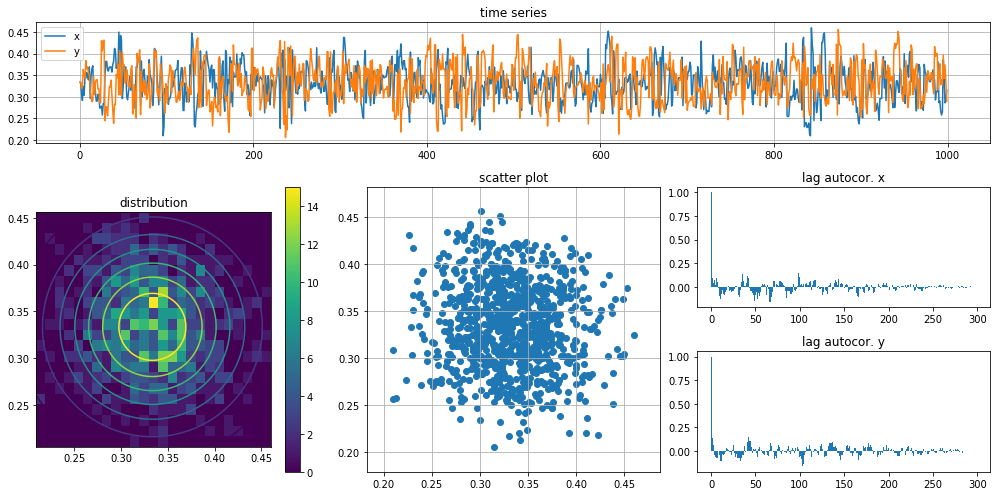

In [15]:
nadapt = 100

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=50)
sampler = hamiltonian.NUTSUpdate(target, momentum_dist, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Spherical HMC
Sampling is by implementation restrained to $[0, 1]^{ndim}$.

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  5.90795602700382
pdf calss:  11593
pot_gradient calls:  95727


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.33021077 0.34139225],[0.00455627 0.00557375],None,0.396


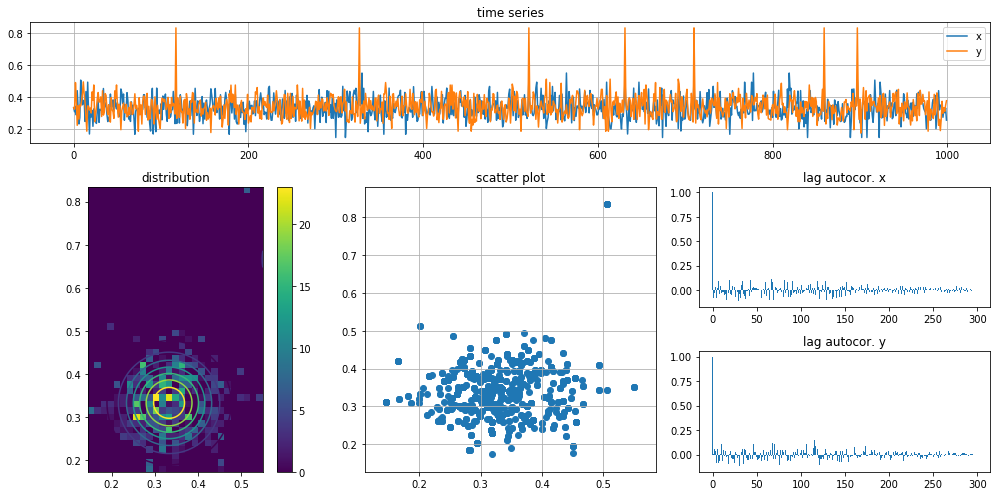

In [16]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

sampler = hamiltonian.StaticSphericalHMC(target, 0.01, 1, 1, 15)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Spherical NUTS

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  7.493433127994649
pdf calss:  18766
pot_gradient calls:  103106


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.43927262 0.42942234],[0.02788718 0.02937176],None,"7.225, p=1.552e-25",0.902


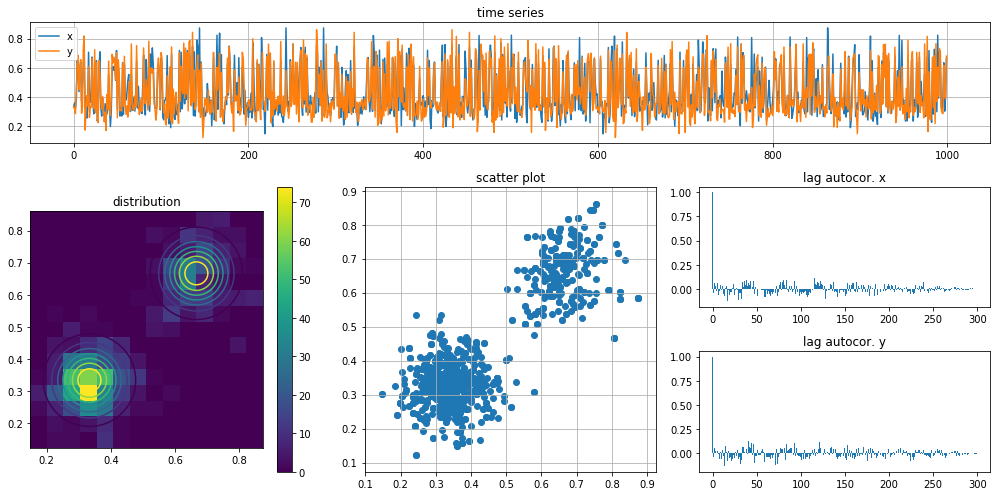

In [17]:
nadapt = 100

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

sampler = hamiltonian.SphericalNUTS(target, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

# Importance Sampling - Metropolis

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.42481352 0.42542463],[0.03204803 0.03652817],None,0.082


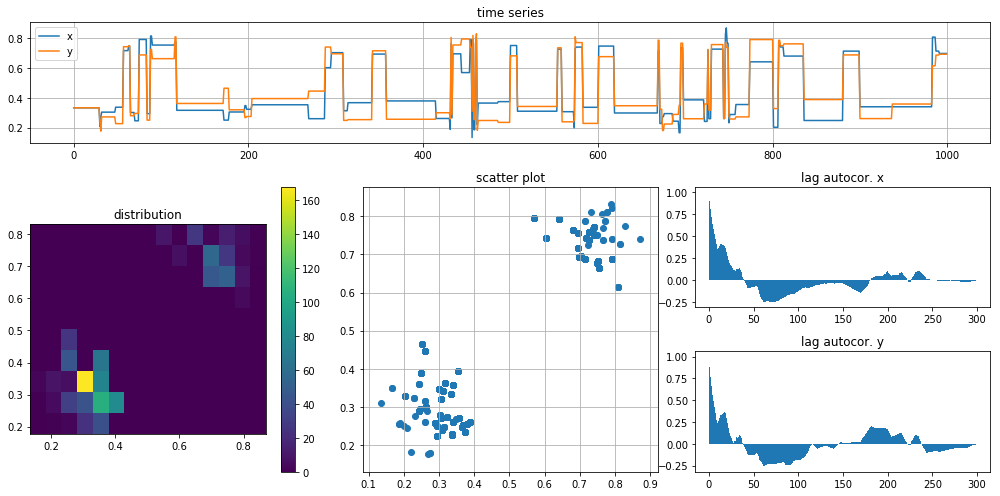

In [18]:
nopt = 1000  # integration steps

# imperfect channels
channels = MultiChannel([
    densities.Gaussian(ndim, mu=1/5, cov=0.005),
    densities.Gaussian(ndim, mu=4/5, cov=0.005)])

# multi channel integrator
importance = MultiChannelMC(channels)

t_start = timer()
integration_sample = importance(target, [], [nopt], []) # integrate

sampler = DefaultMetropolis(ndim, target.pdf, channels)
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

sample

## MC 3
### Uniform local sampler

Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.51094386 0.52058164],[0.03049822 0.02988678],None,"16.81, p=4.614e-62",0.242


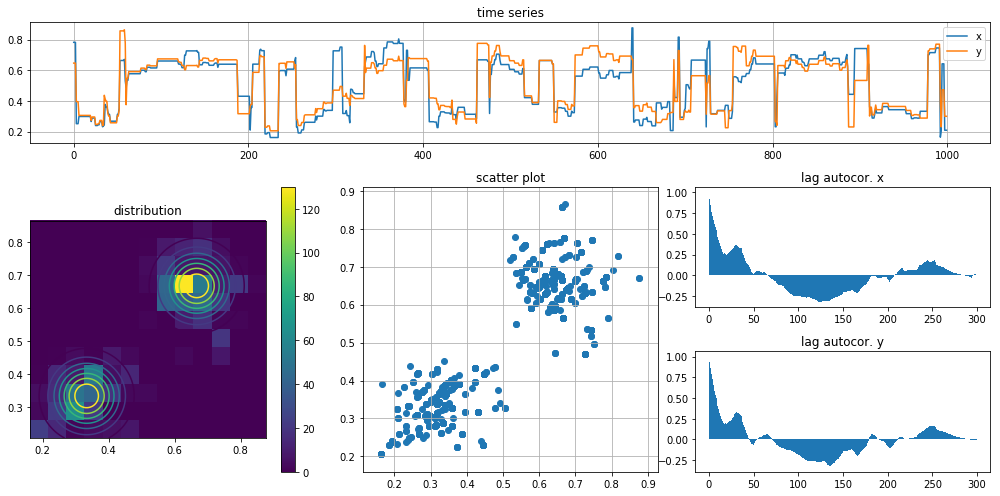

In [19]:
dist = [densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)]
sampler = mc3.MC3Uniform(target, MultiChannel(dist), 0.1, beta=.8)
sample = sampler(([], [1000], []), nsamples)
sample.target = target
sample

### HMC local sampler

Generated 2500 samples.
Generated 5000 samples.
Generated 7500 samples.
Generated 10000 samples.
pdf calss:  104827
pot_gradient calls:  217255


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
10000,[0.5130106 0.51277311],[0.03280119 0.03286726],None,"1.978, p=9.026e-12",0.7477


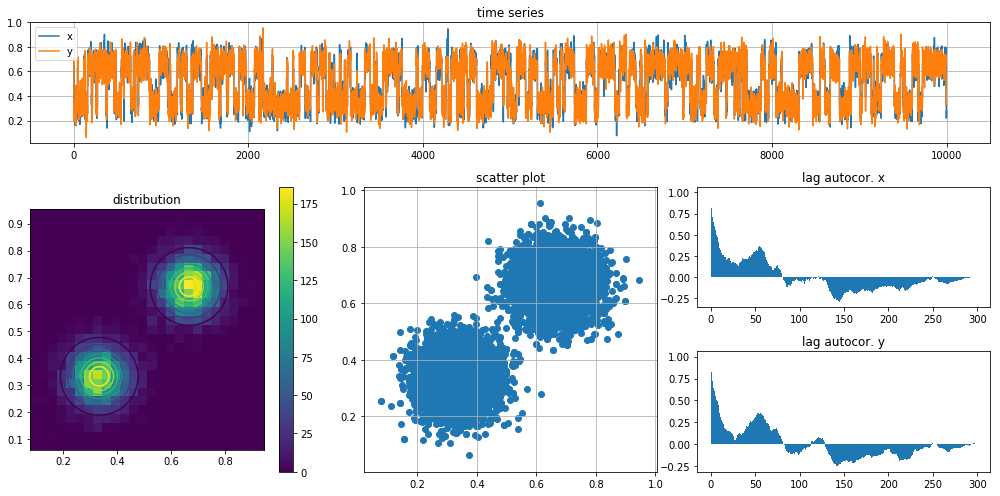

In [25]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

dist = [densities.Gaussian(ndim, mu=np.random.rand(ndim), scale=0.2) for i in range(10)]
sampler = mc3.MC3Hamilton(target, MultiChannel(dist), 10, 10, .1, beta=.3)
sample = sampler(([], [1000], []), 10000, log_every=10000/4)
sample.target = target

print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

### Trigonometric basis surrogate

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calls:  33147
pot_gradient calls:  110751


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.59250277 0.59096061],[0.02535958 0.02654917],None,"3.003, p=0.006181",0.85


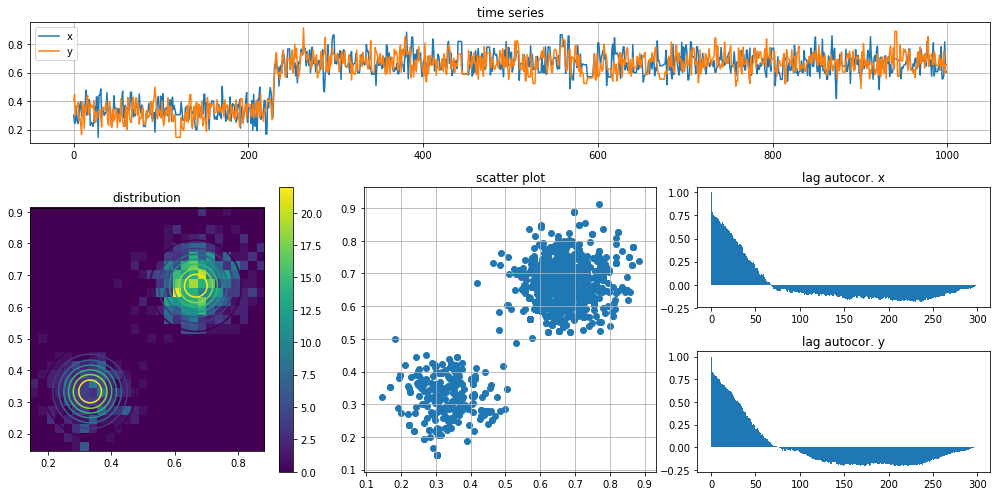

In [21]:
steps = 10
step_size = 0.1
mass = 10
beta = 0
nodes = 1000

# reset counts
target_s = densities.Camel(ndim)

# importance
channels = MultiChannel([densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)])
mc_importance = MultiChannelMC(channels)
integration_sample = mc_importance(target_s, [], [10000], [])

# surrogate
basis = surrogate.extreme_learning.TrigBasis(ndim)
log_vals = -np.ma.log(integration_sample.function_values)
xvals = integration_sample.data[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

params = basis.extreme_learning_train(xvals, log_vals, nodes)
def surr(xs):
    return basis.eval_gradient(*params, xs)
target_s.pot_gradient = surr


# sampling
p_dist = densities.Gaussian(channels.ndim, scale=mass)
sample_hmc = hamiltonian.HamiltonianUpdate(target_s, p_dist, steps, step_size)

sample_is = DefaultMetropolis(ndim, target_s.pdf, channels)

updates = [sample_is, sample_hmc]
mixing_sampler = MixingMarkovUpdate(ndim, updates, [beta, 1-beta])


sample = mixing_sampler.sample(nsamples, [0.3, 0.4], log_every=nsamples/4)
sample.target = target

print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

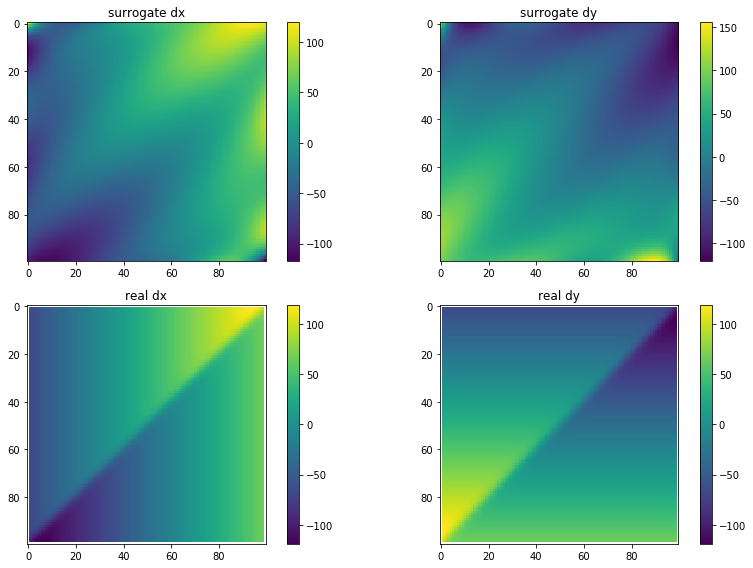

In [21]:
# plot 
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

# fit
out = basis.eval_gradient_split(*params, *mgrid)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title("surrogate dx")
plt.imshow(out[:,:,0])
plt.colorbar()

plt.subplot(222)
plt.title("surrogate dy")
plt.imshow(out[:,:,1])
plt.colorbar()

grad = target.pot_gradient(np.stack((mgrid[0].flatten(), mgrid[1].flatten()), axis=0).transpose()).reshape((*mgrid[0].shape, 2))
plt.subplot(223)
plt.title("real dx")
plt.imshow(grad[:,:,0])
plt.colorbar()

plt.subplot(224)
plt.title("real dy")
plt.imshow(grad[:,:,1])
plt.colorbar()

plt.tight_layout()
plt.show()

### Gaussian radial basis surrogate

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calls:  114847
pot_gradient calls:  110751


Data (size),mean,variance,effective sample size,bin-wise chi^2,acceptance rate
1000,[0.4492684 0.45014774],[0.03072005 0.02973845],None,"2.889, p=3.19e-07",0.892


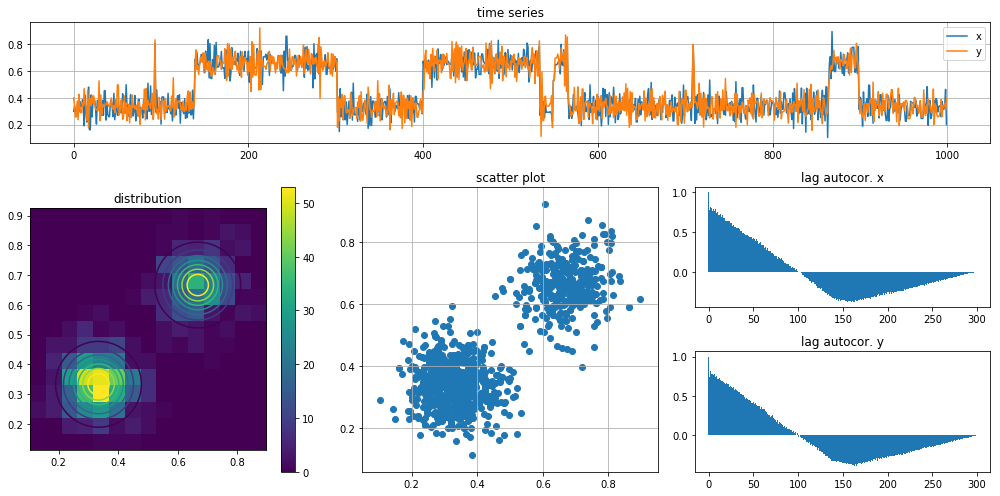

In [22]:
steps = 30
step_size = 0.1
mass = 10
beta = 0.1
nodes = 1000

# reset counts
target_s = densities.Camel(ndim)

# importance
channels = MultiChannel([densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)])
mc_importance = MultiChannelMC(channels)
integration_sample = mc_importance(target_s, [], [10000], [])

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(ndim)
log_vals = -np.ma.log(integration_sample.function_values)
xvals = integration_sample.data[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

params = basis.extreme_learning_train(xvals, log_vals, nodes)
def surr(xs):
    return basis.eval_gradient(*params, xs)
target_s.pot_gradient = surr


# sampling
p_dist = densities.Gaussian(channels.ndim, scale=mass)
sample_hmc = hamiltonian.HamiltonianUpdate(target_s, p_dist, steps, step_size)

sample_is = DefaultMetropolis(ndim, target_s, channels)

updates = [sample_is, sample_hmc]
mixing_sampler = MixingMarkovUpdate(ndim, updates, [beta, 1-beta])


sample = mixing_sampler.sample(nsamples, [0.3, 0.4], log_every=nsamples/4)
sample.target = target

print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

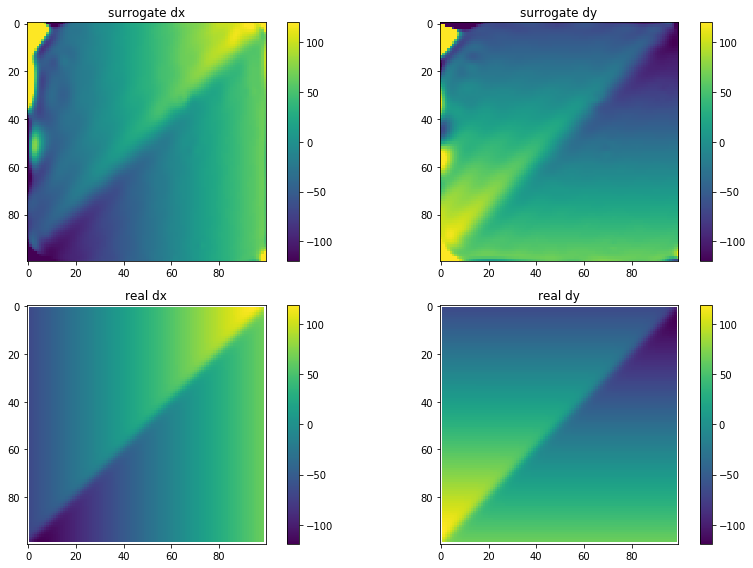

In [23]:
# plot 
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

# fit
out = basis.eval_gradient_split(*params, *mgrid)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title("surrogate dx")
plt.imshow(out[:,:,0], vmin=-120, vmax=120)
plt.colorbar()

plt.subplot(222)
plt.title("surrogate dy")
plt.imshow(out[:,:,1], vmin=-120, vmax=120)
plt.colorbar()

grad = target.pot_gradient(np.stack((mgrid[0].flatten(), mgrid[1].flatten()), axis=0).transpose()).reshape((*mgrid[0].shape, 2))
plt.subplot(223)
plt.title("real dx")
plt.imshow(grad[:,:,0])
plt.colorbar()

plt.subplot(224)
plt.title("real dy")
plt.imshow(grad[:,:,1])
plt.colorbar()

plt.tight_layout()
plt.show()